In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import * 
import torchvision.transforms as transforms 
from pathlib import Path
import os
torch.manual_seed(0) # für pyTorch
random.seed(0)       # für python
print( torch.cuda.get_device_name(0) )
print( torch.__version__ )

NVIDIA GeForce RTX 3070
2.3.0+cu121


In [3]:
path = Path('data/mnist_png/')
sub_directories = [f.path for f in os.scandir(path) if f.is_dir()]
     
image_files = get_image_files(path)
image_files

image_cache = {}

def load_image_from_cache(filename, cls=PILImageBW):
    if filename in image_cache:
        return image_cache[filename]
    image = cls.create(filename)
    image_cache[filename] = image
    return image

def label_function(filename):
    return filename.parents[0].name

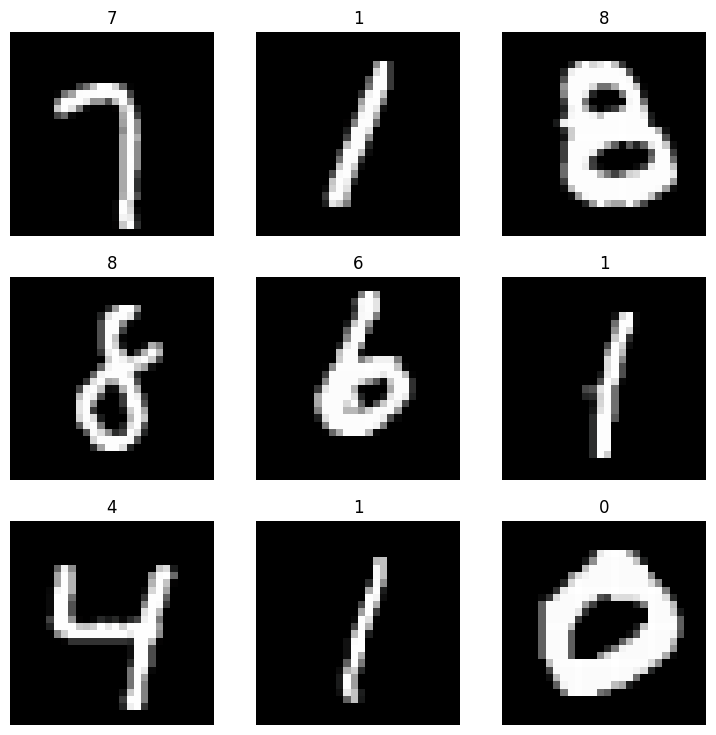

In [4]:
batch_transforms = [Normalize.from_stats(*imagenet_stats)]
splitter = RandomSplitter(valid_pct=0.2, seed=42)

blocks = (ImageBlock(cls=PILImageBW), CategoryBlock)

block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_x=load_image_from_cache,
                  get_y=label_function,
                  splitter=splitter,
                  batch_tfms=batch_transforms)

batch_size = 32
data_loader = block.dataloaders(path, bs=batch_size, num_workers=0)
data_loader.show_batch()

In [7]:
import torch
import torch.nn.functional as F

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [6]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # do your print / debug here
        print(x.shape, type(x))
        return x

In [29]:
def conv_block( n_in, n_out ):
    return nn.Sequential (
        nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

model = nn.Sequential ( 
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
    nn.ReLU(),
    conv_block(32, 32),
    conv_block(32, 32),
    conv_block(32, 32),
    nn.Flatten(),
    nn.Linear(288, 144),
    nn.ReLU(),
    nn.Linear(144, 72),
    nn.ReLU(),
    nn.Linear(72, 10),
)

model.apply(init_weights)

learner = Learner( data_loader, model, metrics=error_rate )
learner.save("custom_net_initial")

print(learner.summary())

Sequential (Input shape: 32 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 28 x 28   
Conv2d                                    896        True      
ReLU                                                           
Conv2d                                    9248       True      
ReLU                                                           
Conv2d                                    9248       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 14 x 14   
MaxPool2d                                                      
Conv2d                                    9248       True      
ReLU                                                           
Conv2d                                    9248       True      
ReLU                                                           
____________________________

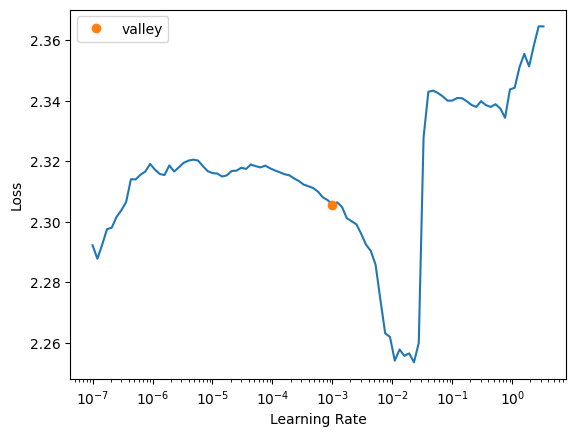

In [30]:
learner.lr_find()
gewaehlteLernrate = 1e-03

epoch,train_loss,valid_loss,error_rate,time
0,0.110085,0.119874,0.038083,00:27
1,0.063918,0.054765,0.016833,00:27
2,0.036038,0.035639,0.009833,00:27
3,0.020820,0.024680,0.006500,00:27
4,0.003607,0.022947,0.006167,00:27


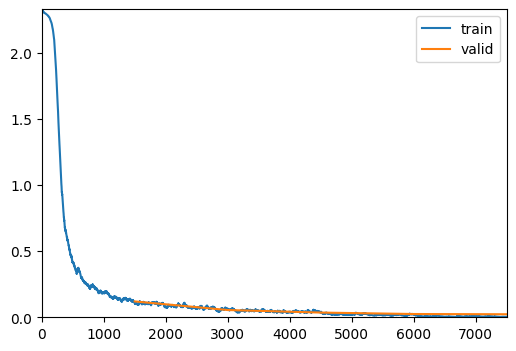

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

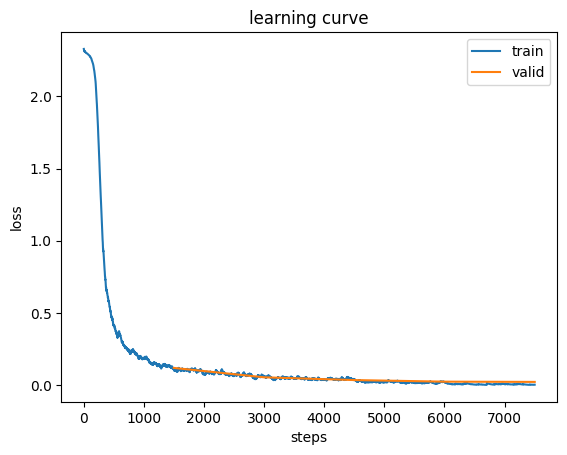

In [31]:
learner.load("custom_net_initial")
learner.fit_one_cycle( 5, lr_max=gewaehlteLernrate, cbs=[ShowGraphCallback()] )
learner.recorder.plot_loss()

In [32]:
learner.save("custom_net_phase1")

Path('models/custom_net_phase1.pth')

Sequential (Input shape: 32 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 28 x 28   
Conv2d                                    896        True      
ReLU                                                           
Conv2d                                    9248       True      
Conv2d                                    9248       True      
____________________________________________________________________________
                     32 x 32 x 14 x 14   
MaxPool2d                                                      
Conv2d                                    9248       True      
Conv2d                                    9248       True      
____________________________________________________________________________
                     32 x 32 x 7 x 7     
MaxPool2d                                                      
Conv2d                                    9248       True      
Conv2d                               

epoch,train_loss,valid_loss,error_rate,time
0,0.147859,0.092491,0.028583,00:28
1,0.076521,0.050651,0.015917,00:28
2,0.042239,0.034239,0.010500,00:29
3,0.019515,0.024463,0.007417,00:28
4,0.006246,0.022595,0.006417,00:28


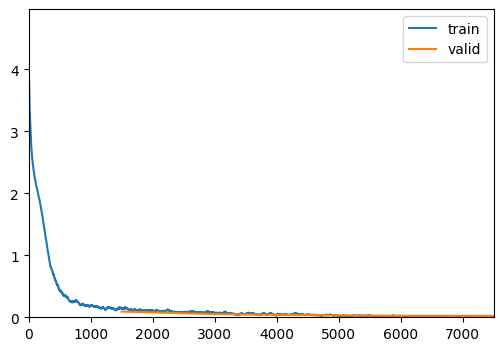

Path('models/custom_resnet_phase1.pth')

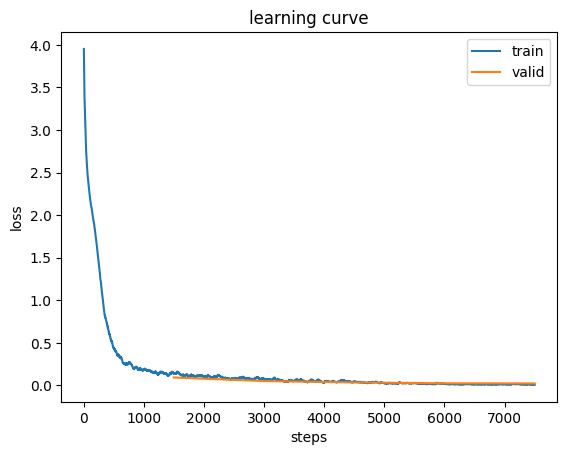

In [33]:
class residual_block(nn.Module):
    def __init__(self, n_in, n_out):
        super(residual_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        r = x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x + r
        x = self.pool(x)
        return x

model = nn.Sequential ( 
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
    nn.ReLU(),
    residual_block(32, 32),
    residual_block(32, 32),
    residual_block(32, 32),
    nn.Flatten(),
    nn.Linear(288, 144),
    nn.ReLU(),
    nn.Linear(144, 72),
    nn.ReLU(),
    nn.Linear(72, 10),
)

model.apply(init_weights)

learner = Learner( data_loader, model, metrics=error_rate )
learner.save("custom_resnet_initial")

print(learner.summary())
learner.fit_one_cycle( 5, lr_max=gewaehlteLernrate, cbs=[ShowGraphCallback()] )
learner.recorder.plot_loss()

learner.save("custom_resnet_phase1")